# Using hyswap to estimate runoff for one and multiple HUC08s

This notebook demonstrates how to use the [hyswap](https://doi-usgs.github.io/hyswap/) python package to estimate runoff over 10 water years (2013-2023) for a set of hydrologic units using streamflow measured at gages that overlap with the hydrologic units of interest. 

This example notebook relies on use of the [dataretrieval](https://github.com/DOI-USGS/dataRetrieval) package for downloading streamflow information from USGS NWIS.

Hydrologic units will be referred to as "hucs" and the drainage area captured by a streamflow gage will be referred to as a "basin".

Please note that warnings in this notebook have been silenced to economize space in the documentation pages, but it is recommended to comment out this line for individual use.

In [1]:
import dataretrieval
import hyswap
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches
from pynhd import WaterData
import warnings
warnings.filterwarnings('ignore')

### Read in huc-basin intersection table

The huc-basin intersection dataset is created using shapefiles for hucs and site drainage basins, and is the output of the [hyswap geospatial data assembly repository](https://code.usgs.gov/water/computational-tools/surface-water-work/hyswap-geospatial-data-assembly) . For each huc-basin intersection, it contains the proportion of the huc's area in the basin, and the proportion of the basin's area in the huc. You can find this file in the 'example_data' folder within the 'example_notebooks' folder in the `hyswap` repository. 

In [2]:
#| tbl-cap: The top rows of the intersection table created by the hyswap geospatial data assembly repository
# This example initially reads in the entire huc_basin_intersection table.
intersection_table_full = pd.read_csv('example_data/huc_props_tbl_conus.csv', 
                             converters = {0:str,1:str,2:str}
                             )

# drop first col that is the index from the csv. 
intersection_table_full.drop(columns=intersection_table_full.columns[0],
                    axis=1,
                    inplace=True
)
# view
intersection_table_full.head()

,da_site_no,huc_id,prop_basin_in_huc,prop_huc_in_basin
0,05014500,17010207,0.002442,0.000066
1,05014500,09040001,0.997161,0.020829
2,05014500,09040002,0.000396,0.000006
3,05015500,17010207,0.001229,0.000066
4,05015500,09040001,0.998572,0.041459


### Select watershed to estimate runoff
This example focuses on a bounding box of HUC08's in Montana and Idaho. We will first filter to one of the hucs to show how to estimate runoff for a single huc, but later on we will estimate runoff for all hucs in the dataset. We will also establish the start and end dates over which we'd like to estimate runoff.

In [3]:
huc_shapes = WaterData('huc08').bybox([-115.065380, 45.947037, -112.692334, 47.572536])

In [4]:
#| tbl-cap: The first few rows of the geopandas dataframe from `pynhd`
huc_shapes.head()

,geometry,id,ogc_fid,tnmid,metasource,sourcedata,sourceorig,sourcefeat,loaddate,gnis_id,areaacres,areasqkm,states,huc8,name,shape_leng,shape_area
0,"MULTIPOLYGON (((-114.57852 46.20392, -114.5776...",huc08.1292,1292,{7F625E44-2D3C-4BFE-B3AF-AE226738BE2E},None,None,None,None,2013-01-18,None,629847,2550.88035,ID,17060301,Upper Selway,3.222792,0.295318
1,"MULTIPOLYGON (((-114.69247 46.37843, -114.6918...",huc08.1293,1293,{2D6097D0-9B6D-4E78-87D7-3C24C9C4544A},None,None,None,None,2013-01-18,None,657072,2661.14160,ID,17060302,Lower Selway,4.501400,0.309359
2,"MULTIPOLYGON (((-114.68911 46.73654, -114.688 ...",huc08.1294,1294,{A3199330-2CD2-4C45-9B94-C3AEFC801329},None,None,None,None,2013-01-18,None,756177,3062.51685,ID,17060303,Lochsa,4.726472,0.358058
3,"MULTIPOLYGON (((-115.07836 47.01436, -115.0778...",huc08.1298,1298,{715E4454-C297-4EE9-BB25-4EF556835571},None,None,None,None,2013-01-18,None,829790,3360.64950,ID,17060307,Upper North Fork Clearwater,3.458673,0.394984
4,"MULTIPOLYGON (((-112.53639 46.77149, -112.5364...",huc08.1314,1314,{C41AF939-24F8-4457-A2CD-18B97877ED3C},None,None,None,None,2013-01-18,None,1199976,4859.90280,MT,17010201,Upper Clark Fork,4.927125,0.567346


In [5]:
#| fig-cap: 'A map of the single HUC08, 17010209'
single_huc = huc_shapes['huc8'][9]

start_date = '2012-10-01'
end_date = '2023-09-30'

huc_shapes[huc_shapes['huc8'] == single_huc].explore()

If we wanted to estimate runoff for one huc, we would first identify which basins intersect the huc using the `identify_sites_from_geom_intersection` function. From this list of basins, we would then download their corresponding gage streamflow data. 

In [6]:
# Pull basin site ids from selected huc8 geom using the hyswap runoff identify sites from geom intersection function
basins_overlap_single_huc = hyswap.runoff.identify_sites_from_geom_intersection(geom_id = single_huc,
                                   geom_intersection_df = intersection_table_full,
                                   geom_id_column_name='huc_id',
                                   site_column_name='da_site_no',
                                   prop_geom_in_basin_col='prop_huc_in_basin',
                                   prop_basin_in_geom_col='prop_basin_in_huc'
                                   )

# output should be long list of sites ids. These are all the site_ids within the selected huc8 polygon
num_sites = len(basins_overlap_single_huc)
print(f'There are {num_sites} gaged basins that overlap this huc.')

There are 67 gaged basins that overlap this huc.


### Custom function for grabbing gage flow data from `dataretrieval` and converting it to runoff    
To estimate runoff for a huc, we need to create a dictionary of runoff data, where each key corresponds to a site id for a basin, and the item is a dataframe with a datetime index and runoff values for that site in a 'runoff' column. The function below leverages `dataretrieval` to pull streamflow data for a set of input sites over a specified date range, and then uses `hyswap`'s `streamflow_to_runoff` function in the `runoff` module to estimate area-based runoff using site drainage areas. It produces runoff values in millimeters per day. Note that this function can take some time, depending upon the size/number of queries. Additionally, it is not unusual for many sites to return no data.

In [7]:
def query_nwis_runoff_data(sites,
    start_date,
    end_date):
    print("Pulling site streamflow data and converting it to runoff. This may take some time...")
    # first, pull site info 
    info_df, _ = dataretrieval.nwis.get_info(sites=sites)
    # convert drainage area from sq mi to sq km
    info_df['da'] = info_df['drain_area_va'] * 2.58998811
    # info_df = info_df[['da', 'site_no']]
    # get streamflow data between start and end date
    dv_df = dataretrieval.nwis.get_record(
        sites=sites, parameterCd='00060',
        start=start_date, end=end_date,
        multi_index=False,
        service='dv'
        )
    df_nwis_ro_data = pd.DataFrame()

    if not dv_df.empty:
        # get site ids from dv_df and create empty
        # df to hold site runoff data
        siteids = dv_df['site_no'].unique().tolist()

        # Loop through sites retrieved from nwis and estimate
        # runoff using hyswap function
        for site in siteids:
            ro_df = dv_df[dv_df['site_no']==site]
            da = info_df.loc[info_df['site_no']==site]['da']
            ro_df = hyswap.runoff.streamflow_to_runoff(ro_df, '00060_Mean', da, time_unit='day')
            df_nwis_ro_data = pd.concat([df_nwis_ro_data, ro_df])
        # print proportion of sites with data
        prop = len(siteids)/len(sites)
        print(f'\nProp of successful nwis queries from list of sites:\n {prop}')
    else:
        print(f"No site data available, returning empty dataframe")
    
    return(df_nwis_ro_data)

### Download gage data
Let's try using `query_nwis_runoff_data` to download streamflow data and convert it to runoff (in mm/day) from 2013-2023 for our selected huc '17010209'. Note that not all gage sites listed in `basins_overlap_single_huc` will necessarily have data for the date range specified.

In [8]:
df_nwis_ro_data = query_nwis_runoff_data(basins_overlap_single_huc,
start_date = start_date,
end_date = end_date)
df_nwis_ro_data.head()

Pulling site streamflow data and converting it to runoff. This may take some time...



Prop of successful nwis queries from list of sites:
 0.5074626865671642


,site_no,00060_Mean,00060_Mean_cd,runoff
datetime,,,,
2012-10-01 00:00:00+00:00,06185500,10000.0,A,0.105125
2012-10-02 00:00:00+00:00,06185500,10100.0,A,0.106176
2012-10-03 00:00:00+00:00,06185500,10200.0,A,0.107227
2012-10-04 00:00:00+00:00,06185500,10300.0,A,0.108278
2012-10-05 00:00:00+00:00,06185500,10300.0,A,0.108278


### Estimate runoff for the huc
With daily basin runoff data in hand, we are ready to estimate runoff for the huc in mm/day. Please reference `hyswap`'s [Calculations](https://doi-usgs.github.io/hyswap/meta/calculations.html) page to understand how runoff is estimated using this function. Briefly, this function identifies basins contained within the huc and basins that contain the huc that have runoff data for the entire time period in the dataset. It then estimates a weighted mean runoff value for each day using applicable and available basins. If `clip_downstream_basins` is set to True, the function only uses the smallest basin that contains the huc and disregards downstream gages that represent larger basins that contain the huc. This example will loop through each water year and estimate runoff using basins with complete records for each water year.

In [9]:
# get water year in dataset so can loop by water year to estimate runoff
df_nwis_ro_data['water_year'] = df_nwis_ro_data.index.year
df_nwis_ro_data['water_year'][df_nwis_ro_data.index.month >= 10] = df_nwis_ro_data['water_year'] + 1
        
# create df to hold estimate results
results = pd.DataFrame()
        
    # loop through each water year
for year, df_year in df_nwis_ro_data.groupby(df_nwis_ro_data.water_year):

    # estimate runoff for each water year of data
    single_huc_runoff = hyswap.calculate_geometric_runoff(
        geom_id=single_huc,
        runoff_df=df_year,
        geom_intersection_df=intersection_table_full,
        site_column_name='da_site_no',
        geom_id_column_name='huc_id',
        prop_geom_in_basin_col='prop_huc_in_basin',
        prop_basin_in_geom_col='prop_basin_in_huc',
        percentage=False,
        clip_downstream_basins=False,
        full_overlap_threshold=0.98
        )
            
                # concatenate with previous years runoffs
    results = pd.concat([results, single_huc_runoff])

Let's take a quick look at the estimated runoff.

<Axes: title={'center': 'Estimated Runoff for HUC 17010209'}, xlabel='Date', ylabel='Runoff (mm)'>

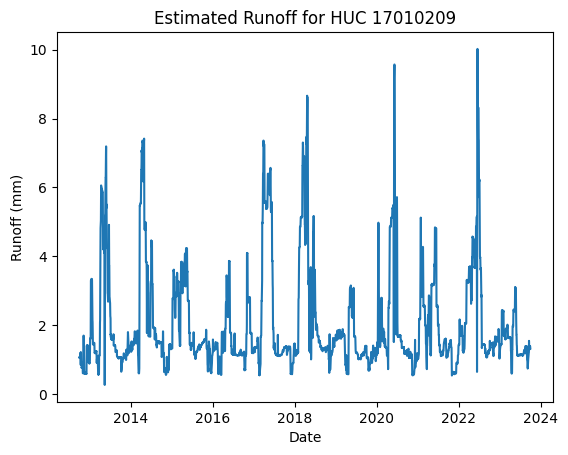

In [10]:
#| fig-cap: A runoff hydrograph for huc 17010209 using the `hyswap.plot_hydrograph` function
hyswap.plot_hydrograph(
    results,
    data_column_name='estimated_runoff',
    title=f'Estimated Runoff for HUC {single_huc}',
    yscale='linear',
    ylab='Runoff (mm)')

### Estimate runoff for all hucs
Now, we will estimate runoff for all of the hucs in the region selected. First, we'll identify the sites with drainage basins that intersect the seven hucs. Next, we'll need to use our custom function to download flow data and estimate runoff for each basin. Finally, we can leverage `hyswap`'s `calculate_multiple_geometric_runoff`, which loops through a list of hucs, finds their intersecting gage basins, and estimates runoff for each day in the dataset. Note that by setting the `clip_downstream_basins` argument to True, the function is only considering basins within each HUC08 and the smallest basin containing each HUC08 in the runoff estimate.

In [11]:
list_site_ids = []

# loop through to get all sites (identify_sites_from_geom_intersection() cannot accept multiple geom_ids) 
for huc in huc_shapes['huc8']:
    sites = hyswap.runoff.identify_sites_from_geom_intersection(
        geom_id = huc,
        geom_intersection_df = intersection_table_full,
        geom_id_column_name='huc_id',
        site_column_name='da_site_no',
        prop_geom_in_basin_col='prop_huc_in_basin',
        prop_basin_in_geom_col='prop_basin_in_huc'
        )
    
    list_site_ids.append(sites)

# join list of lists, as for loop above separates out the list of dfs 
all_site_ids = sum(list_site_ids,[])

In [12]:
# grab basin data using the all_site_ids list
df_nwis_ro_data = query_nwis_runoff_data(all_site_ids, start_date=start_date,
end_date=end_date)

Pulling site streamflow data and converting it to runoff. This may take some time...



Prop of successful nwis queries from list of sites:
 0.11346863468634687


In [13]:
%%capture
# get water year in dataset so can loop by water year to estimate runoff
df_nwis_ro_data['water_year'] = df_nwis_ro_data.index.year
df_nwis_ro_data['water_year'][df_nwis_ro_data.index.month >= 10] = df_nwis_ro_data['water_year'] + 1
        
# create df to hold estimate results
results = pd.DataFrame()
        
# loop through each water year
for year, df_year in df_nwis_ro_data.groupby(df_nwis_ro_data.water_year):
    # subset data to water year
    df_nwis_ro_data_sub = df_nwis_ro_data[df_nwis_ro_data['water_year'] == year]
    
    multiple_huc_runoff = hyswap.runoff.calculate_multiple_geometric_runoff(
        geom_id_list = huc_shapes['huc8'],
        runoff_df = df_nwis_ro_data,
        geom_intersection_df=intersection_table_full,
        site_column_name='da_site_no',
        geom_id_column_name='huc_id',
        prop_geom_in_basin_col= 'prop_huc_in_basin',
        prop_basin_in_geom_col='prop_basin_in_huc',
        percentage=False,
        clip_downstream_basins=True,
        full_overlap_threshold=0.98
        )
    results = pd.concat([results, multiple_huc_runoff])

Like our single huc runoff calculation, we can take a look at the estimated runoff across multiple hucs. Because there are 16 HUCs in this dataset, we will only plot a subset below using the `pivot_table` function from `pandas`.

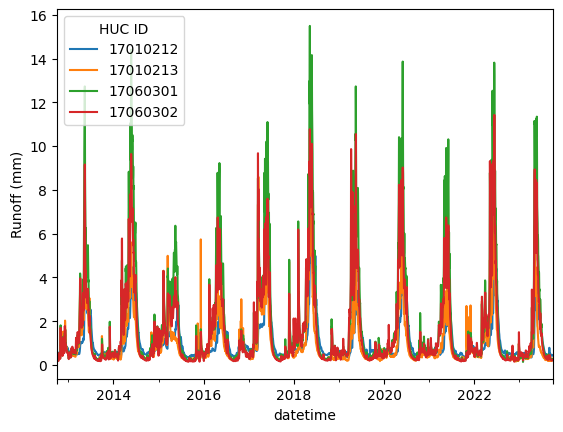

In [14]:
#| fig-cap: A multiple runoff hydrograph for all hucs pulled from `pynhd` in this example
# Plot 
results_plot = results.pivot_table(index=results.index, columns='geom_id', values='estimated_runoff')
ax = results_plot.iloc[:, 10:14].plot()
ax.set_ylabel("Runoff (mm)")
ax.legend(title='HUC ID')
plt.show()

### Mapping the results of the runoff calculation
In this step of the analysis, we will estimate variable percentiles by day for each huc, and then use those percentiles to estimate a percentile for a new estimated runoff value. We will then plot these percentiles in a map of the hucs.  

In [15]:
huc_ids = results['geom_id'].unique()

percentile_results = {}

for huc_id in huc_ids:
    results_sub = results[results['geom_id'] == huc_id]
    results_sub.sort_index(inplace=True)
    percentiles = hyswap.calculate_variable_percentile_thresholds_by_day(results_sub,
                                                                         data_column_name='estimated_runoff')
    percentile_results[huc_id] = percentiles

Now, we will pull a new set of gage streamflow data for the first day of the next water year, and estimate runoff.

In [16]:
%%capture
start_date = '2023-10-01'
end_date = '2023-10-01'
# grab basin data using the all_site_ids list
df_nwis_ro_data_new = query_nwis_runoff_data(all_site_ids, start_date=start_date, end_date=end_date)

multiple_huc_runoff_new = hyswap.runoff.calculate_multiple_geometric_runoff(
    geom_id_list = huc_shapes['huc8'],
    runoff_df = df_nwis_ro_data_new,
    geom_intersection_df=intersection_table_full,
    site_column_name='da_site_no',
    geom_id_column_name='huc_id',
    prop_geom_in_basin_col= 'prop_huc_in_basin',
    prop_basin_in_geom_col='prop_basin_in_huc',
    percentage=False,
    clip_downstream_basins=True,
    full_overlap_threshold=0.98
    )

With runoff in hand, we can then calculate the percentile for this date for each HUC08, based on the percentiles we calculated for the previous 5-year period.

In [17]:
# Calculate estimated streamflow percentile for the new data by interpolating against
# the previously calculated percentile threshold levels
huc_perc_df = pd.DataFrame()

for huc, huc_df in multiple_huc_runoff_new.groupby('geom_id', group_keys=False):
    huc_perc_df = pd.concat([huc_perc_df, hyswap.percentiles.calculate_multiple_variable_percentiles_from_values(
            huc_df,'estimated_runoff', percentile_results[huc])])
# categorize streamflow by the estimated streamflow percentiles
huc_perc_df = hyswap.utils.categorize_flows(huc_perc_df, 'est_pct', schema_name="NWD")
huc_perc_df = huc_perc_df.reset_index(level='datetime')

And finally, create an interactive map showing HUC08 runoff percentiles for October 1, 2023.

In [18]:
#| fig-cap: 'HUC08 colors correspond to the runoff percentiles for 10-01-2023 flow based on 5 years of estimated runoff data at the HUC08 scale, derived from gage basin flow data.'
# merge percentile information to geodataframe with polygon geometry
huc_shapes_percs = huc_shapes.merge(huc_perc_df.set_index('geom_id'), left_on='huc8', right_index=True)
# set up gdf format for plotting - ex. get rid of datetimes/timestamps
huc_shapes_percs['Date'] = huc_shapes_percs['datetime'].dt.strftime('%Y-%m-%d %H:%M')
schema = hyswap.utils.retrieve_schema('NWD')
flow_cond_cmap = schema['colors']
if 'low_color' in schema:
                flow_cond_cmap = [schema['low_color']] + flow_cond_cmap
if 'high_color' in schema:
                flow_cond_cmap = flow_cond_cmap + [schema['high_color']]
# set NA values to "Not Ranked" category
huc_shapes_percs['flow_cat'] = huc_shapes_percs['flow_cat'].cat.add_categories('Not Ranked')
huc_shapes_percs.loc[huc_shapes_percs['est_pct'].isna(), 'flow_cat'] = 'Not Ranked'
flow_cond_cmap = flow_cond_cmap + ['#d3d3d3'] # light grey
# renaming columns with user friendly names for map
huc_shapes_percs = huc_shapes_percs.drop(['loaddate', 'datetime'], axis=1)
huc_shapes_percs = huc_shapes_percs.rename(columns={'estimated_runoff':'Runoff (mm/day)',
                                                'est_pct':'Estimated Percentile',
                                                'huc8':'HUC08 ID',
                                                'name':'HUC08 Name',
                                                'flow_cat':'Streamflow Category'})
# Create map of runoff 
huc_shapes_percs.explore(
    column="Streamflow Category",
    cmap=flow_cond_cmap,
    tooltip=["HUC08 ID", 'HUC08 Name',"Streamflow Category", "Runoff (mm/day)", "Estimated Percentile", "Date"],
    tiles="CartoDB Positron",
    marker_kwds=dict(radius=5),
    legend_kwds=dict(caption='Daily Mean Runoff Category'))